# Company Sales Forecasting

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import math
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')

Read Data

In [2]:
data = pd.read_excel('C:/Users/palla/OneDrive/Documents/3SC Case Study/CocaCola_Sales_Rawdata.xlsx')
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


Check for missing value & outliers.There's none

Quarter    False
Sales      False
dtype: bool


<AxesSubplot:>

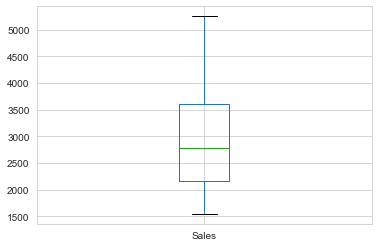

In [3]:
print(data.isna().any())
data.boxplot()

<AxesSubplot:xlabel='Quarter'>

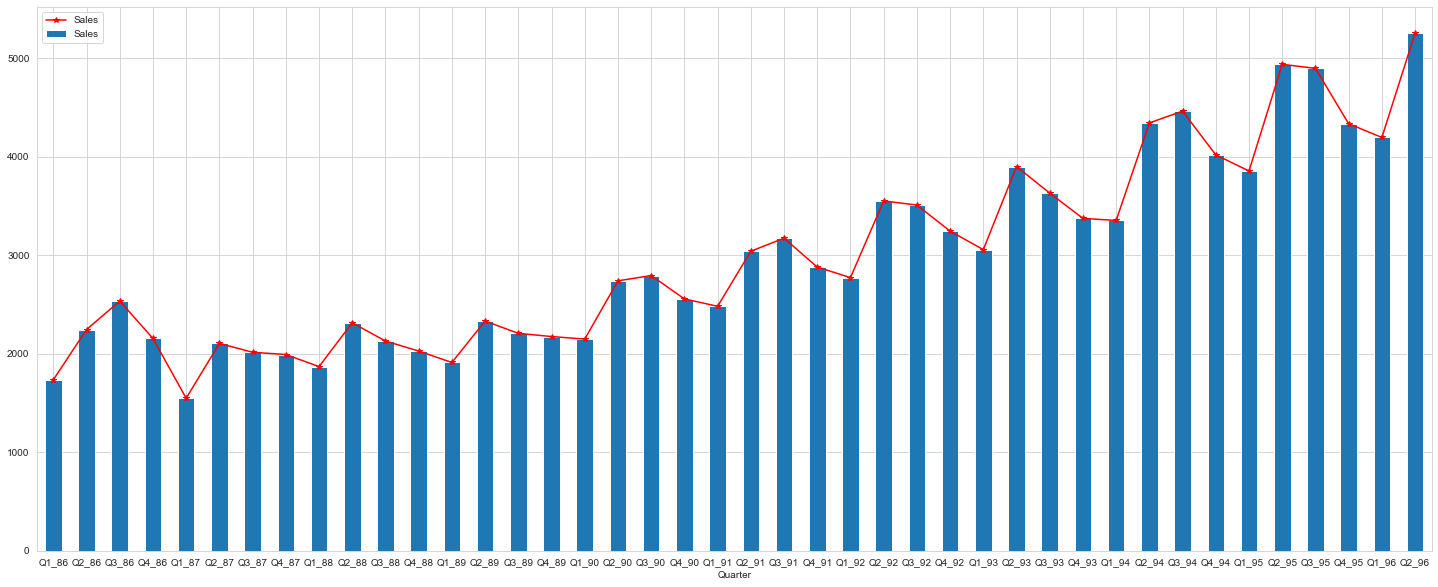

In [4]:
fig,ax = plt.subplots()
data.plot(x='Quarter',y='Sales',kind='bar',figsize=(25,10),ax=ax)
data.plot(x='Quarter',y='Sales',kind='line',marker='*',figsize=(25,10),ax=ax,color='red')

Convert 'Quarter' column in pandas datetime format, in order to make it a time series.

In [5]:
qs = data['Quarter'].str.replace(r'(Q\d)_(\d+)', r'19\2-\1')
data['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
data.set_index('date',drop=True,inplace=True)
data.drop('Quarter',inplace=True,axis=1)
data.head()

,Sales
date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996


For additive model, there is some randomness in residual, so seasonality should not be additive.

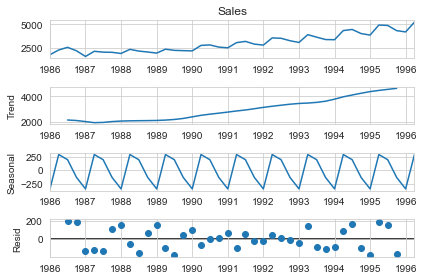

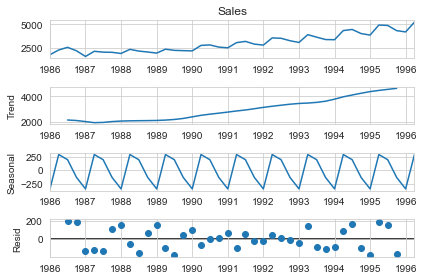

In [6]:
decompose_add = seasonal_decompose(data.Sales,model="additive")
decompose_add.plot()

For multiplicative model, residual seems to be constant, so seasonality is multiplicative. That means seasonality is varying over time.

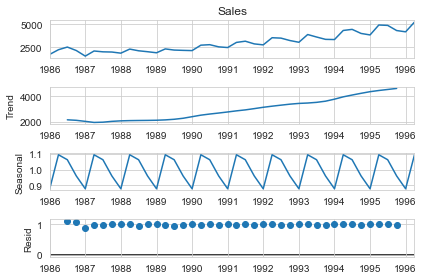

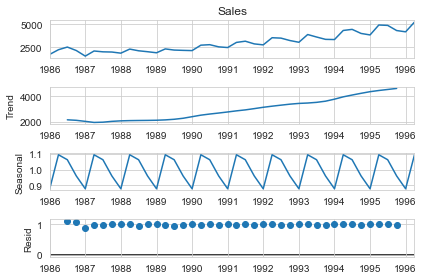

In [7]:
decompose_mul = seasonal_decompose(data.Sales,model="multiplicative")
decompose_mul.plot()

<AxesSubplot:ylabel='Density'>

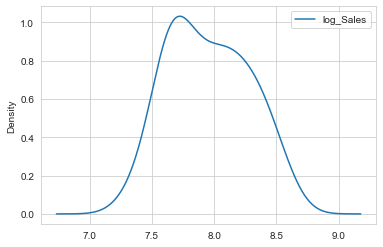

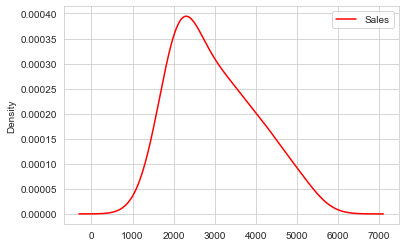

In [8]:
data['log_Sales'] = np.log(data['Sales'])
data.plot(y='log_Sales',kind='density')
data.plot(y='Sales',kind='density',color='red')

In [9]:
print(shapiro(data['Sales']))
print(shapiro(data['log_Sales']))

ShapiroResult(statistic=0.9352941513061523, pvalue=0.019624589011073112)
ShapiroResult(statistic=0.9658941626548767, pvalue=0.23886467516422272)


# Applying Holts-Winter Method of Exponential Smoothing

The best model suited for this data would be Holt's Winter Exponential smoothing taking both trend and seasonality coefficient.
As residuals are not very much varying so a much complex model may not work well, this is shown below using SARIMA model on the same data.

RMSE : 217.00651393437565 , MAE : 181.71728412379684 , MAPE : 0.03831897380494734


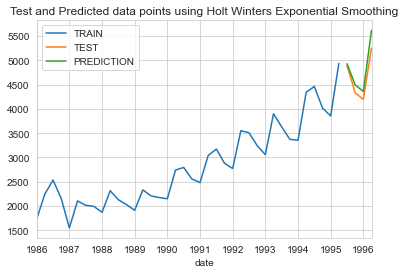

In [10]:
train= data[['Sales']].head(38)
test=data[['Sales']].tail(4)
fitted_model = ExponentialSmoothing(train['Sales'],trend='mul',seasonal='mul',seasonal_periods=4).fit()
test_predictions = fitted_model.forecast(4)
train['Sales'].plot(legend=True,label='TRAIN')
test['Sales'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Test and Predicted data points using Holt Winters Exponential Smoothing')
test['Predicted Sales'] = test_predictions
test['Error'] = test['Sales'] - test['Predicted Sales']
RMSE = math.sqrt((test['Error']**2).mean())
MAE = test['Error'].abs().mean()
MAPE = (test['Error'].abs()/test['Sales']).mean()
print(f'RMSE : {RMSE} , MAE : {MAE} , MAPE : {MAPE}')

RMSE : 150.2514144080615 , MAE : 121.00634948816491 , MAPE : 0.02555274828295127


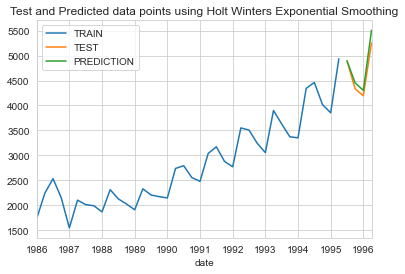

In [11]:
train= data[['Sales']].head(38)
test=data[['Sales']].tail(4)
fitted_model = ExponentialSmoothing(train['Sales'],trend='add',seasonal='mul',seasonal_periods=4).fit()
test_predictions = fitted_model.forecast(4)
train['Sales'].plot(legend=True,label='TRAIN')
test['Sales'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Test and Predicted data points using Holt Winters Exponential Smoothing')
test['Predicted Sales'] = test_predictions
test['Error'] = test['Sales'] - test['Predicted Sales']
RMSE = math.sqrt((test['Error']**2).mean())
MAE = test['Error'].abs().mean()
MAPE = (test['Error'].abs()/test['Sales']).mean()
print(f'RMSE : {RMSE} , MAE : {MAE} , MAPE : {MAPE}')

# Using Seasonal ARIMA

This is just to try a better and complex model, but as the data is pretty simple and nicely distributed this may not work as good as earlier Holt's Winter Exponential Smoothing.

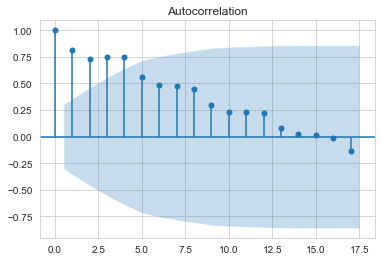

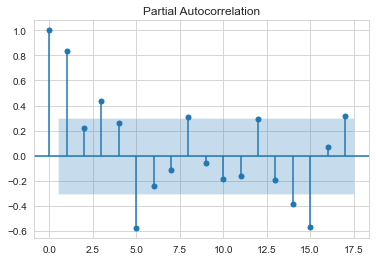

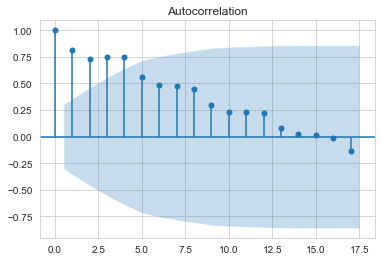

In [12]:
plot_pacf(data['Sales'])
plot_acf(data['Sales'])

In [13]:
ad_fuller_result = adfuller(data['Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
for key, value in ad_fuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: 1.3094210153268104
p-value: 0.9966611673930905
Critial Values:
   1%, -3.639224104416853
Critial Values:
   5%, -2.9512301791166293
Critial Values:
   10%, -2.614446989619377


Differencing data by lag 1, to make trend stationary. Plot shows that no trend is visible, but seasonality still appears.

Text(0.5, 1.0, 'Log Difference of Quarterly Sales for trend stationarity')

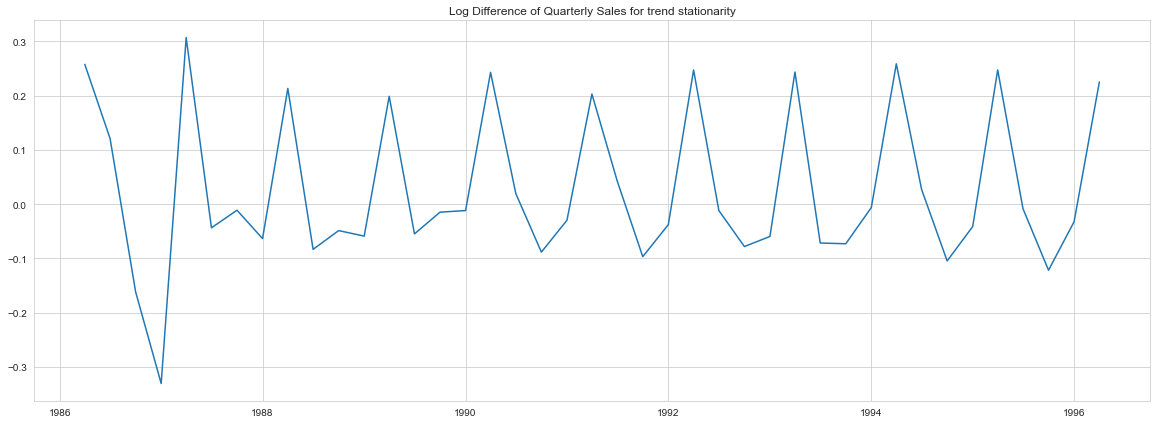

In [14]:
dt = data[['log_Sales']]
dt['log_Sales'] = dt['log_Sales'].diff()
dt = dt.drop(dt.index[0])
plt.figure(figsize=[20, 7])
plt.plot(dt['log_Sales'])
plt.title("Log Difference of Quarterly Sales for trend stationarity")

Differencing data by lag 4 as we have quarterly data, to make seasonal stationary. Plot shows that no trend or seasonality is present, so we are good to go with our SARIMA model.

Text(0.5, 1.0, 'Log Difference of Quarterly Sales for seasonal stationarity')

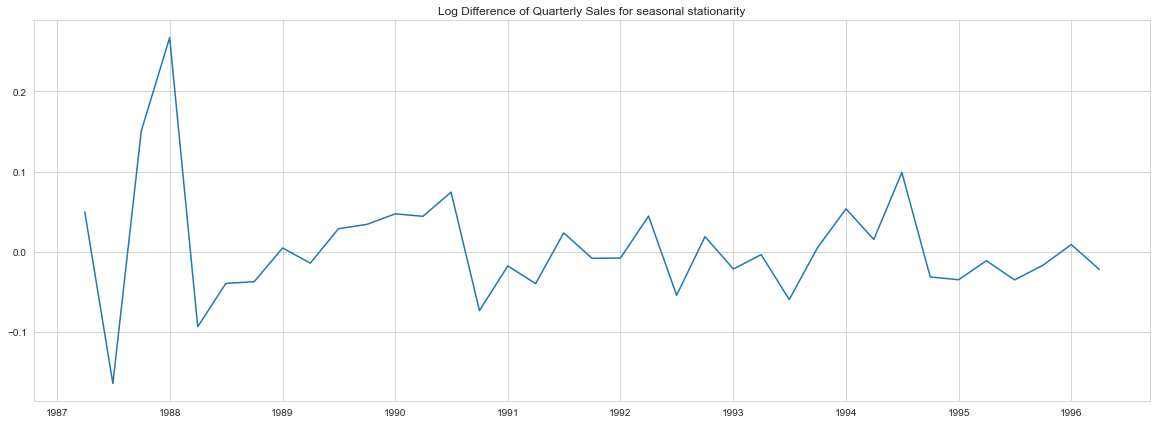

In [15]:
dt['log_Sales'] = dt['log_Sales'].diff(4)
dt = dt.drop(dt.index[0:4])
plt.figure(figsize=[20, 7])
plt.plot(dt['log_Sales'])
plt.title("Log Difference of Quarterly Sales for seasonal stationarity")

ADF test also confirms stationarity as p-value <<< 0.05 and test statistics << all critical values.

In [16]:
ad_fuller_result = adfuller(dt['log_Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
for key, value in ad_fuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -6.291161346117244
p-value: 3.596463125419349e-08
Critial Values:
   1%, -3.626651907578875
Critial Values:
   5%, -2.9459512825788754
Critial Values:
   10%, -2.6116707716049383


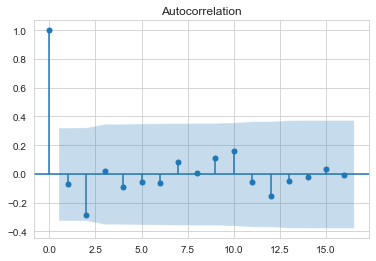

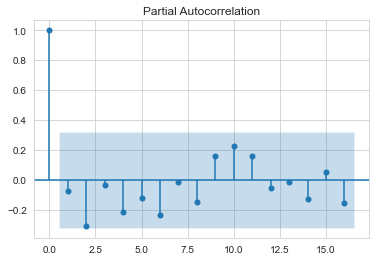

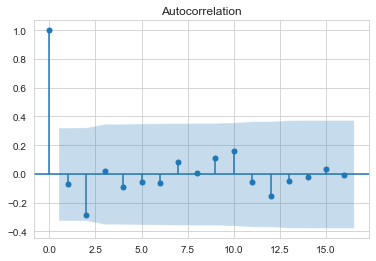

In [17]:
plot_pacf(dt['log_Sales'])
plot_acf(dt['log_Sales'])

Function to return SARIMA results with different combinations of parameters.

In [18]:
def optimize_SARIMA(parameters_list, d, D, s,endog):
    """
        Return dataframe with parameters, corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

Passing different values of parameters making total 16 combinations.

In [19]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

16


Calling function to get AIC value from different combinations. Less be the AIC better be the model

In [20]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, dt['log_Sales'])
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 1, 1, 0)",-58.449718
1,"(0, 1, 0, 1)",-58.063191
2,"(1, 1, 1, 0)",-56.873884
3,"(0, 1, 1, 1)",-56.433604
4,"(1, 1, 0, 1)",-56.151150
5,"(1, 1, 1, 1)",-54.998010
6,"(0, 1, 0, 0)",-54.747589
7,"(1, 1, 0, 0)",-52.897661
8,"(1, 0, 0, 1)",-44.608316
9,"(1, 0, 1, 0)",-44.354871


Using best parameters to traing model and get the model summary and different metrics.

In [21]:
best_model = SARIMAX(dt['log_Sales'], order=(0, 1, 1), seasonal_order=(1, 1, 0, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          log_Sales   No. Observations:                   37
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 4)   Log Likelihood                  32.225
Date:                            Sun, 05 Nov 2023   AIC                            -58.450
Time:                                    13:55:24   BIC                            -54.053
Sample:                                04-01-1987   HQIC                           -56.992
                                     - 04-01-1996                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9982      8.910     -0.112      0.911     -18.461      16.464
ar.S.L4       -0.5408      0.183   

Plotting Actual and forecsted values, where can be observed model not fitting as good as previous Holt's Winter Exponential Smoothing.

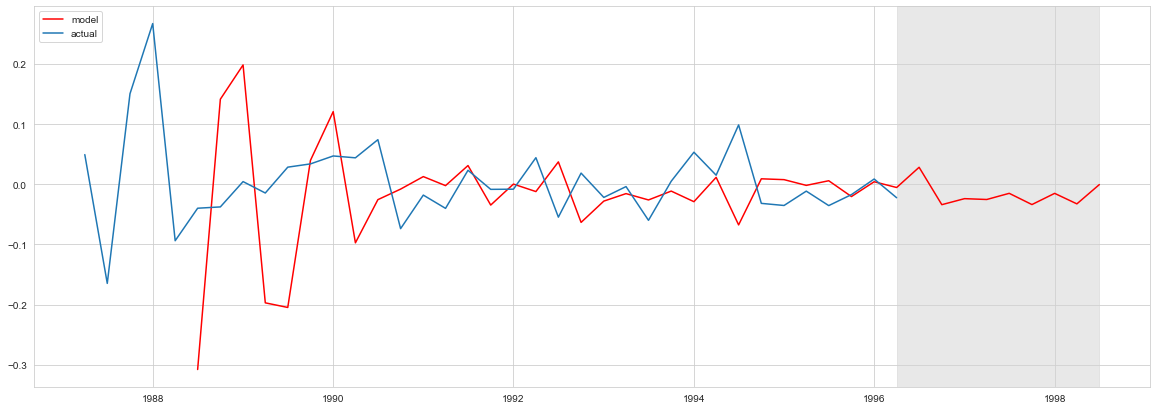

In [22]:
dt['sarima_model'] = best_model.fittedvalues
dt['sarima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=dt.shape[0], end=dt.shape[0] + 8)
forecast = dt['sarima_model'].append(forecast)

plt.figure(figsize=(20, 7))
plt.plot(forecast, color='r', label='model')
plt.axvspan(dt.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(dt['log_Sales'], label='actual')
plt.legend()

# End of Analysis